In [ ]:
!pip install kaggle nibabel torch numpy pyvista --quiet

In [ ]:
import kagglehub
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from skimage.measure import marching_cubes
from scipy.ndimage import zoom

In [ ]:
path = kagglehub.dataset_download("andrewmvd/liver-tumor-segmentation")

print("Path to dataset files:", path)

100%|██████████| 4.84G/4.84G [00:46<00:00, 111MB/s] 

Extracting files...


In [ ]:
src = "/root/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5"
dst = "/content/liver-tumor-segmentation"

shutil.move(src, dst)

print("Dataset moved to:", dst)

Dataset moved to: /content/liver-tumor-segmentation


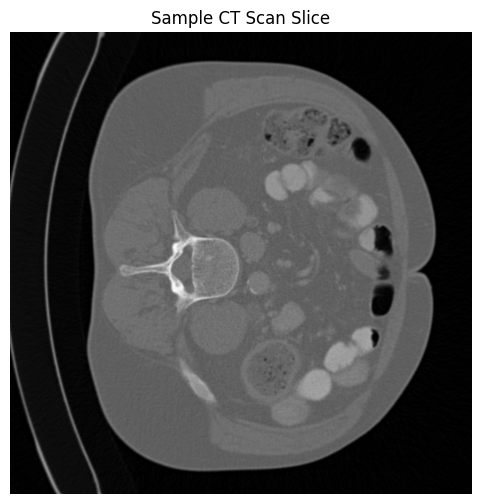

In [ ]:
# Sample
sample_nii_file = "/content/liver-tumor-segmentation/volume_pt1/volume-3.nii"

nii_img = nib.load(sample_nii_file)
nii_data = nii_img.get_fdata()

# Show the middle slice of the 3D volume
mid_slice = nii_data.shape[2] // 2

plt.figure(figsize=(6, 6))
plt.imshow(nii_data[:, :, mid_slice], cmap="gray")  # Display a single slice
plt.axis("off")
plt.title("Sample CT Scan Slice")
plt.show()

In [ ]:
# Create the necessary directories under /content/data
os.makedirs("/content/data/volumes", exist_ok=True)
os.makedirs("/content/data/segmentations", exist_ok=True)

volume_paths = []
segmentation_paths = []

volume_paths.append(f"/content/liver-tumor-segmentation/volume_pt1/volume-0.nii")
for x in range(1, 51):
    volume_paths.append(f"/content/liver-tumor-segmentation/volume_pt{(x - 1) // 10 + 1}/volume-{x}.nii")

for x in range(51):
    segmentation_paths.append(f"/content/liver-tumor-segmentation/segmentations/segmentation-{x}.nii")

# Move the volumes and segmentations to the new directories
for i in range(10):
    volume_file = volume_paths[i]
    volume_dest = f"/content/data/volumes/volume-{i}.nii"
    shutil.move(volume_file, volume_dest)

    segmentation_file = segmentation_paths[i]
    segmentation_dest = f"/content/data/segmentations/segmentation-{i}.nii"
    shutil.move(segmentation_file, segmentation_dest)

print("Dataset successfully moved to /content/data")

Dataset successfully moved to /content/data


In [ ]:
# Calculate the variance of each slice along the z-axis
def calculate_variance(img_data):
    return np.var(img_data, axis=(0, 1))

# Resize (crop or pad) volumes and segmentations to 264 slices using variance
def resize_to_target_depth(img_data, target_depth):
    z_size = img_data.shape[2]

    if z_size > target_depth:
        # Calculate the variance for each slice
        importance_scores = calculate_variance(img_data)

        # Sort the slices by their variance (highest to lowest)
        sorted_indices = np.argsort(importance_scores)[::-1]

        # Select the top `target_depth` slices
        selected_slices = sorted_indices[:target_depth]
        selected_slices = np.sort(selected_slices)  # Sort back in original order

        # Crop the volume to retain the most informative slices
        img_data_resized = img_data[:, :, selected_slices]
    elif z_size < target_depth:
        # Pad the volume with zero slices to match the target depth
        pad_slices = target_depth - z_size
        pad_before = pad_slices // 2
        pad_after = pad_slices - pad_before

        # Pad along the z-axis
        img_data_resized = np.pad(img_data, ((0, 0), (0, 0), (pad_before, pad_after)), mode='constant')
    else:
        # No change needed if the volume already has the target depth
        img_data_resized = img_data

    return img_data_resized

volume_paths = [f"/content/data/volumes/volume-{i}.nii" for i in range(51)]
segmentation_paths = [f"/content/data/segmentations/segmentation-{i}.nii" for i in range(51)]

# Create output directories
os.makedirs("/content/data/volumes_resized", exist_ok=True)
os.makedirs("/content/data/segmentations_resized", exist_ok=True)

# Process volumes and segmentations
for i in range(51):
    # Load the volume and segmentation data
    volume_img = nib.load(volume_paths[i])
    volume_data = volume_img.get_fdata()

    segmentation_img = nib.load(segmentation_paths[i])
    segmentation_data = segmentation_img.get_fdata()

    target_depth = 264

    # Resize the volume and segmentation to 264 slices
    volume_resized = resize_to_target_depth(volume_data, target_depth)
    segmentation_resized = resize_to_target_depth(segmentation_data, target_depth)

    # Save the resized volumes and segmentations
    volume_resized_img = nib.Nifti1Image(volume_resized, volume_img.affine)
    segmentation_resized_img = nib.Nifti1Image(segmentation_resized, segmentation_img.affine)

    nib.save(volume_resized_img, f"/content/data/volumes_resized/volume-{i}.nii")
    nib.save(segmentation_resized_img, f"/content/data/segmentations_resized/segmentation-{i}.nii")

print("Resizing complete: All volumes and segmentations are resized to 264 slices.")

Resizing complete: All volumes and segmentations are resized to 264 slices.


In [ ]:
volume_folder = "/content/data/volumes_resized"
segmentation_folder = "/content/data/segmentations_resized"

def load_nii_file(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Create a custom dataset class to handle loading in batches
class MedicalDataset(Dataset):
    def __init__(self, volume_paths, segmentation_paths):
        self.volume_paths = volume_paths
        self.segmentation_paths = segmentation_paths

    def __len__(self):
        return len(self.volume_paths)

    def __getitem__(self, idx):
        # Load the volume and segmentation data
        volume_data = load_nii_file(self.volume_paths[idx])
        segmentation_data = load_nii_file(self.segmentation_paths[idx])

        # Convert to tensors and add batch and channel dimensions
        volume_data = torch.tensor(volume_data).unsqueeze(0).float()  # (1, 512, 512, 264)
        segmentation_data = torch.tensor(segmentation_data).unsqueeze(0).float()  # (1, 512, 512, 264)

        return volume_data, segmentation_data

# Generate paths for volumes and segmentations
volume_paths = [os.path.join(volume_folder, f"volume-{i}.nii") for i in range(51)]
segmentation_paths = [os.path.join(segmentation_folder, f"segmentation-{i}.nii") for i in range(51)]

# Create the dataset and dataloader
dataset = MedicalDataset(volume_paths, segmentation_paths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Check one batch to confirm
volume_batch, segmentation_batch = next(iter(dataloader))
print(f"Volume batch shape: {volume_batch.shape}")
print(f"Segmentation batch shape: {segmentation_batch.shape}")

Volume batch shape: torch.Size([1, 1, 512, 512, 264])
Segmentation batch shape: torch.Size([1, 1, 512, 512, 264])


In [ ]:
# # Define the UNet
# class UNet3D(nn.Module):
#     def __init__(self):
#         super(UNet3D, self).__init__()
#         self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv3d(128, 1, kernel_size=3, padding=1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         return self.sigmoid(x)  # Output segmentation

# model = UNet3D()

# volume_batch, segmentation_batch = next(iter(dataloader))

# model.eval()
# with torch.no_grad():
#     output = model(volume_batch)

# print(f"Input volume shape: {volume_batch.shape}")
# print(f"Model output shape: {output.shape}")

# # Convert to NumPy
# output_np = output.squeeze().detach().cpu().numpy()

# # Apply threshold to generate binary segmentation (0 or 1)
# binary_segmentation = (output_np > 0.5).astype(np.uint8)

# # Apply Marching Cubes for 3D mesh reconstruction
# verts, faces, _, _ = marching_cubes(binary_segmentation, level=0)

# # Convert to PyVista Mesh
# mesh = pv.PolyData(verts, np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int64))

# # Visualize the 3D Mesh
# plotter = pv.Plotter()
# plotter.add_mesh(mesh, color="lightblue", opacity=0.7, show_edges=True)
# plotter.show()

# # Save the 3D Mesh to an OBJ file
# mesh.save("segmentation_mesh.obj")

# # Save as STL (alternative)
# mesh.save("segmentation_mesh.stl")

# print("Mesh saved successfully as 'segmentation_mesh.obj' and 'segmentation_mesh.stl'.")